In [1]:
%%capture
from matplotlib import pyplot as plt
import numpy as np
import imageio
import cv2

%pylab inline

In [2]:
def image_size(image):
    if image.ndim == 2:
        return image.shape
    else:
        return image.shape[:-1]


# Lab 2
In this assignment you will perform some simple geometric transformations on images and see an application of these transformations.

Instructions:

1. Proceed cell by cell. Each cell already has some code, but it is incomplete. 
2. You are required to fill in the missing details. The places where you are expected to supply code begin and end with `# <---` and `# --->` respectively.
3. Please read the comments carefully to understand what is being asked of you.
4. All the images are inside `images/` and have already been imported. 
5. Make sure that you always do Target-Source (T-S) mapping.

In [3]:
# Load images
import base64
import io


img1 = imageio.imread('./img1.jpg', format='JPG')
img2 = imageio.imread('./img2.jpg', format='JPG')

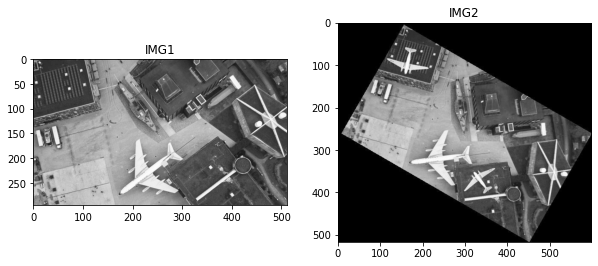

In [4]:
# View images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('IMG1')

ax2.imshow(img2, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('IMG2')

plt.show()

## Occlusion Detection



We begin by writing a function for bilinear interpolation.

In [5]:
def bilinear_interpolation(source_image, source_point):
    """
    Computes the intensity at `source_point` by bilinearly interpolating
    intensities in the immediate 2 X 2 neighborhood of the `source_point`.
    
    Args:
        source_image (np.array): The source image
        source_point (float, float): The source point
        
    Returns:
        uint8: Pixel intensity at source_point
    """
    i_s, j_s = source_point
    
    # Floor `i_s` to get `i`
    i = int(np.floor(i_s))
    
    # Similarly, compute `j`
    # <---
    j = int(np.floor(j_s))
    # --->
    
    # The co-ordinates of the top-left (`tl`) corner are simply (i, j)
    tl = i, j
    
    # Write down the co-ordinates of the remaining three corners
    # (top-right, bottom-left, bottom-right) below.
    # Use the variable names `tr`, `bl`, `br` respectively. 
    
    # <---
    tr = i, j+1
    bl = i+1, j
    br = i+1,j+1 
    # --->
    
    # Next, we compute the distance of `source_point` from top-left corner along
    # vertical and horizontal directions separately.
    del_i, del_j = i_s - i, j_s - j
    
    # Create a variable called `pixel_intensity` and assign the
    # pixel value obtained by bilinearly interpolating pixel values
    # at tl, tr, bl, br.
    # Use `del_i`, `del_j` computed in the previous step to obtain
    # the weights for interpolation.
    # <---
    pixel_intensity = (1 - del_i) * (1 - del_j) * source_image[tl] + (1 - del_i) * del_j * source_image[tr] + del_i * (1 - del_j) * source_image[bl] + del_i * del_j * source_image[br]
    # --->
    
    return np.uint8(pixel_intensity)

Next, we use the above function to implement a function that performs
an arbitrary T-S transformation on a source image.

In [6]:
def transform(source_image, transformation, target_size=None):
    """
    Transforms `source_image` as dictated by `transformation`. 
    
    Note that this function does T-S mapping. So, `transformation` is actually from Target to Source.
    
    Args:
    
        source_image (np.array): The source image
        transformation (np.array): 3 x 3 transformation matrix
        target_size (uint, uint): Size of the target_image
        
    Returns:
        np.array: Transformed image
    """
    source_rows, source_cols = image_size(source_image)
    
    # When no `target_size` is supplied, `target_image` will be the same size as `source_image`
    target_rows, target_cols = target_size if target_size else (source_rows, source_cols)
    target_image = np.zeros((target_rows, target_cols), dtype=np.uint8)
    
    # We iterate over each pixel in `target_image` and assign the appropriate intensity
    for i_t in range(target_rows):
        for j_t in range(target_cols):
            
            # Map each target point (`i_t`, `j_t`) through `transformation`
            # to obtain its corresponding source_point (`i_s`, `j_s`)
            # <---
            i_s, j_s, v = np.array([i_t, j_t, 1]) @ transformation.T
            i_s, j_s = i_s / v, j_s / v
            # --->
            
            # We ignore all target points whose source points lie outside the
            # source image. All these intensities remain 0.
            if 0 <= i_s < source_rows - 1 and 0 <= j_s < source_cols - 1:
                # Assign the intensity value of target_image at (i_t, j_t) using the
                # bilinear interpolation function above.
                
                # <---
                target_image[i_t, j_t] = bilinear_interpolation(source_image, (i_s, j_s))
                # --->
    
    return target_image

`IMG1.png`, `IMG2.png` are two aerial images of an airport parking bay. These images were
captured using two cameras placed at different locations and at different instants of time but over-
looking the same area. It is known that the images are related by an in-plane rotation and translation.
The following point correspondences are given:

| Correspondence | IMG1 (i, j) | IMG2 (i, j) |
|----------------|-------------|-------------|
| 1 | (29, 124) | (93, 248) |
| 2 | (157, 372) | (328, 399) |

Determine the changes in `IMG2.png` with respect to `IMG1.png`.

Finding the difference is a natural way to determine changes between two images. However, we must first ensure that the images we are subtracting were taking from the same position and orientation. 
Clearly, that is not the case here. We fix this by first finding the transformation from `IMG1` to `IMG2`. 
Next, we align `IMG2` to `IMG1` using this transformation (which acts as T-S mapping). Once aligned, we are free to subtract and look for any differences.

In [7]:
def find_rt(points):
    """
    Computes the transformation (involving only rotation & translation) matrix
    given 2 pairs of corresponding points.
    
    Args:
        points (np.array): 2 x 2 x 2 np.array that holds the point correspondences.
                           Each slice holds points in one image. So, points[:, :, 0] has points
                           in IMG1, while points[:, :, 1] has points in IMG2
        
    Returns:
        np.array: Transformation matrix
    """
    
    A = np.zeros((4, 4), dtype=np.float64)
    A[np.arange(4), [2, 3, 2, 3]] = 1
    A[0::2, 0:2] = points[0]
    A[1::2, 0:2] = np.flip(points[0], 1)
    A[0::2, 1] *= -1
    b = points[1].reshape(-1, order='C')
    x = np.linalg.solve(A, b)
    T = np.array([[x[0], -x[1], x[2]],
                  [x[1], x[0], x[3]],
                  [0, 0, 1]])
    return T

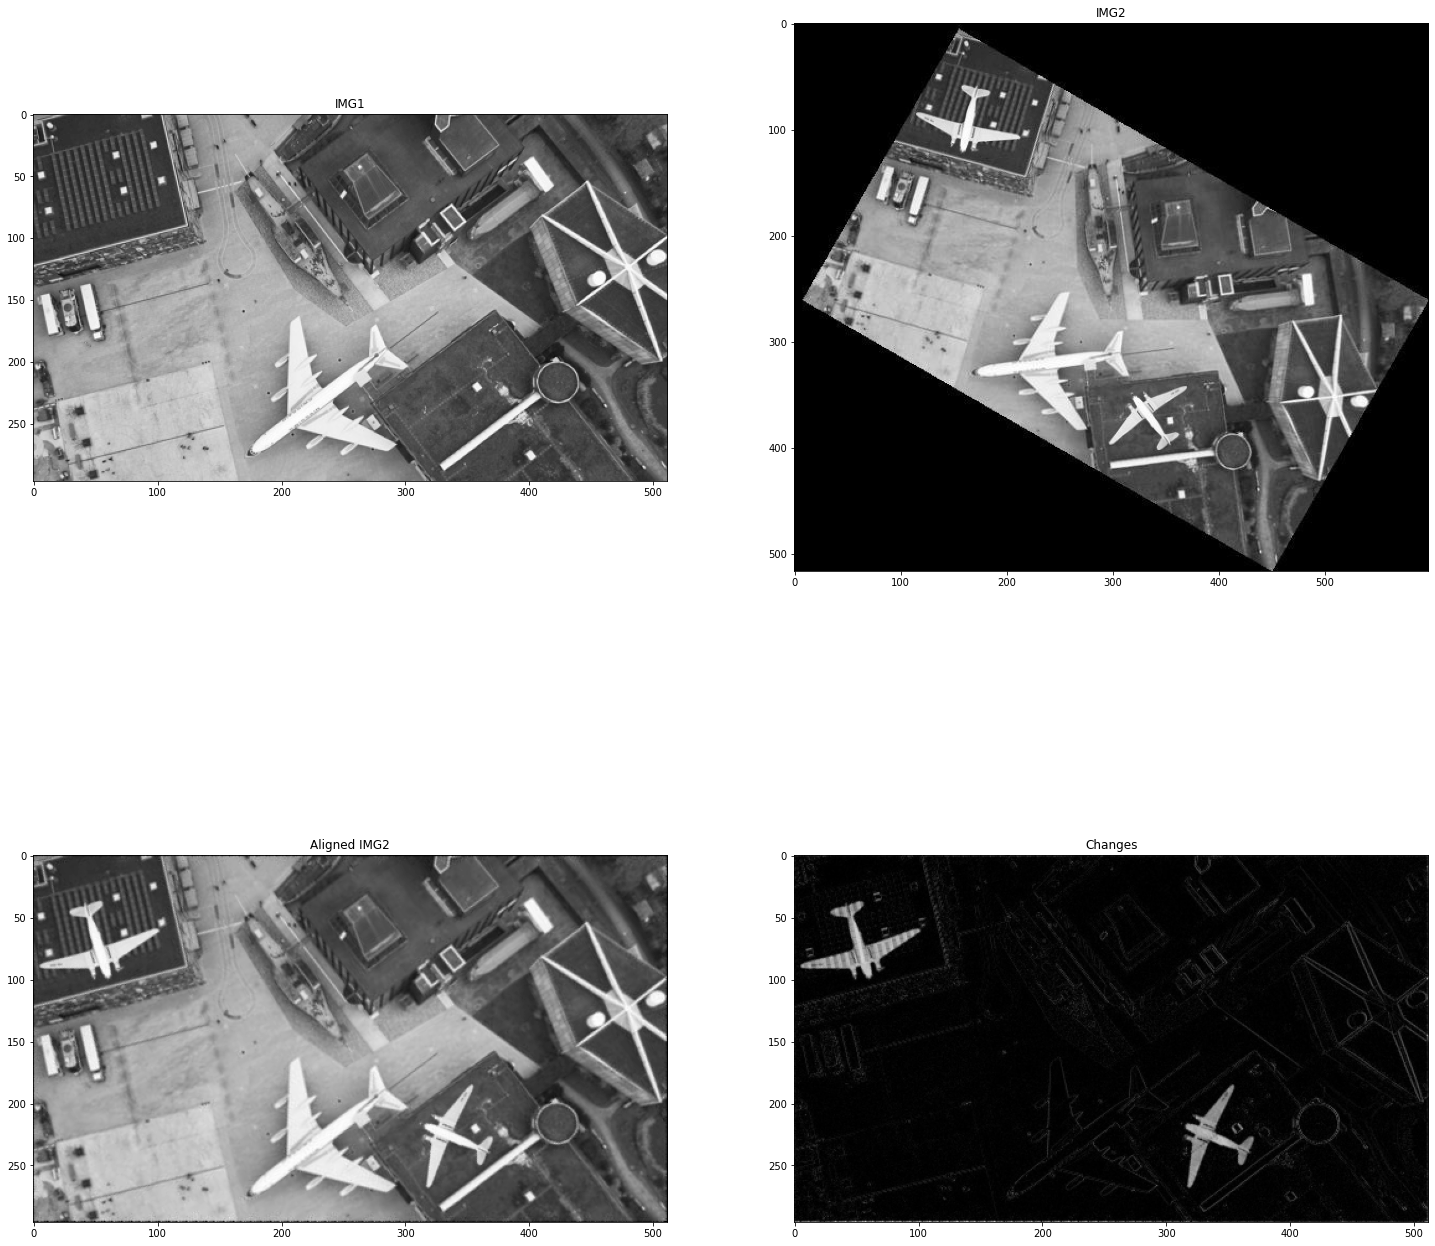

In [8]:
# Create a variable called `correspondences` and fill
# it point correspondences given in the table above.
# Make sure that you fill it in the format expected
# by `find_rt` (read its documentation)
# <---
correspondences = np.array([[[29, 124],[157, 372]],[[93, 248],[328, 399]]])
# --->
T = find_rt(correspondences)


# Align `img2` with `img1` using the `T` above and the `transform` function.
# Make sure that the aligned image is the same size as `img1`.
# <---
img2_aligned =transform(img2, T, img1.shape)
# --->

# Subtract the aligned img2 and img1 to notice any changes. 
# Name the difference as `diff_img`.
# <---
diff_img = np.abs(img2_aligned.astype(np.float64) - img1.astype(np.float64)).astype(np.uint8)
# --->

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))

ax1.imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('IMG1')

ax2.imshow(img2, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('IMG2')

ax3.imshow(img2_aligned, cmap=plt.cm.gray, vmin=0, vmax=255)
ax3.set_title('Aligned IMG2')

ax4.imshow(diff_img, cmap=plt.cm.gray, vmin=0, vmax=255)
ax4.set_title('Changes')

plt.show()